In [2]:
import numpy as np
import jax.numpy as jnp
import jax
import bayes3d as b
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2
import trimesh
import os
import glob
import bayes3d.neural
import pickle
# Can be helpful for debugging:
# jax.config.update('jax_enable_checks', True) 
from bayes3d.neural.segmentation import carvekit_get_foreground_mask
# import genjax
from tqdm import tqdm

GenJAX not installed. Importing bayes3d without genjax dependencies.


In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [4]:
paths = glob.glob(
    # "panda_dataset/*.pkl"
    "panda_scans_v6/*.pkl"
)
all_data = pickle.load(open(paths[0], "rb"))
IDX = 1
data = all_data[IDX]

dict_keys(['rgbPixels', 'depthPixels', 'segmentationMaskBuffer', 'camera_pose', 'camera_matrix'])


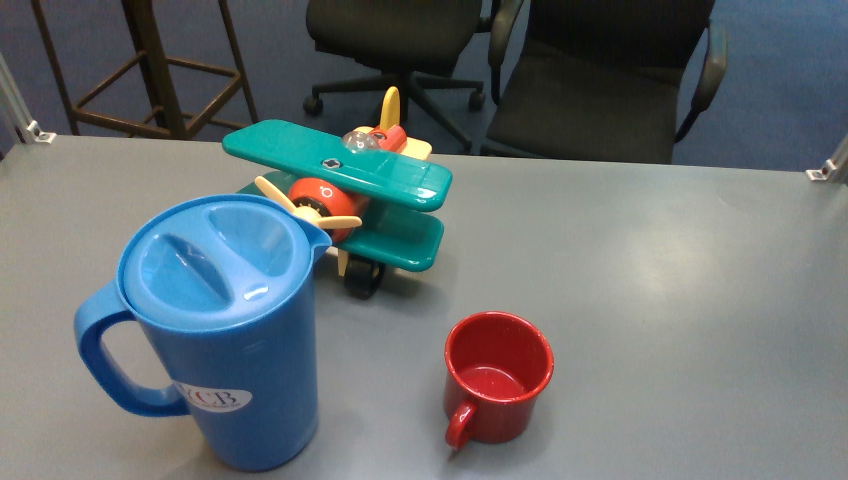

In [5]:
print(data["camera_image"].keys())
K = data["camera_image"]['camera_matrix'][0]
rgb = data["camera_image"]['rgbPixels']
depth = data["camera_image"]['depthPixels']
camera_pose = data["camera_image"]['camera_pose']
camera_pose = b.t3d.pybullet_pose_to_transform(camera_pose)
fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
h,w = depth.shape
near = 0.001
rgbd_original = b.RGBD(rgb, depth, camera_pose, b.Intrinsics(h,w,fx,fy,cx,cy,0.001,10000.0))
b.get_rgb_image(rgbd_original.rgb)

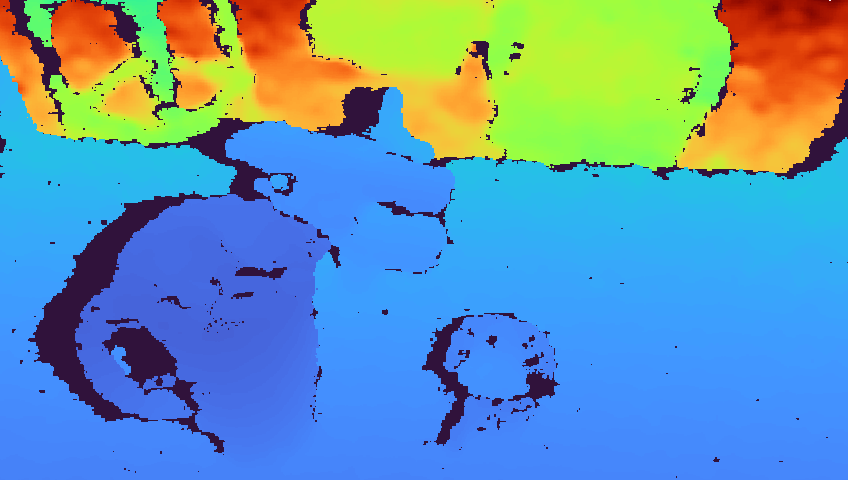

In [6]:
b.get_depth_image(rgbd_original.depth)

In [7]:
scaling_factor = 0.19
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd_original, scaling_factor)

In [8]:
table_pose, plane_dims = b.utils.infer_table_plane(
    b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics),jnp.eye(4),
    rgbd_scaled_down.intrinsics,
    ransac_threshold=0.001, inlier_threshold=0.001, segmentation_threshold=0.1
)
face_child = 3

In [10]:
b.clear()
b.show_cloud("1", b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics).reshape(-1,3))
b.show_pose("table", table_pose)

In [11]:
b.setup_renderer(rgbd_scaled_down.intrinsics)
b.RENDERER.add_mesh_from_file("toy_plane.ply")
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(13+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(10+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (192, 96, 1024)
Centering mesh with translation [0.   0.   0.09]


In [12]:
width = 0.03
ang = jnp.pi
num_position_grids = 51
num_angle_grids = 51
contact_param_deltas = b.utils.make_translation_grid_enumeration_3d(
    -width, -width, -ang,
    width, width, ang,
    num_position_grids,num_position_grids,num_angle_grids
)

grid_params = [
    (0.5, jnp.pi, (15,15,15)), (0.2, jnp.pi, (15,15,15)), (0.1, jnp.pi, (15,15,15)),
    (0.05, jnp.pi/3, (15,15,15)),
    (0.02, jnp.pi, (9,9,51))
    , (0.01, jnp.pi/5, (15,15,15)),
      (0.01, 0.0, (31,31,1)),(0.05, 0.0, (31,31,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

In [13]:
_cp_to_pose = lambda cp, index: table_pose @ b.scene_graph.relative_pose_from_edge(cp, face_child, b.RENDERER.model_box_dims[index])
cps_to_pose= jax.vmap(_cp_to_pose, in_axes=(0,0,))
cps_to_pose_jit = jax.jit(cps_to_pose)
cps_to_pose_parallel = jax.vmap(cps_to_pose, in_axes=(0,None,))
cps_to_pose_parallel_jit = jax.jit(cps_to_pose_parallel)

key = jax.random.PRNGKey(30)

def score_images(rendered, observed):
    return -jnp.linalg.norm(observed - rendered, axis=-1).mean()

# def score_images(rendered, observed):
#     mask = observed[...,2] < intrinsics.far
#     return (jnp.linalg.norm(observed - rendered, axis=-1)* (1.0 * mask)).sum() / mask.sum()

def score_images(rendered, observed):
    return -jnp.linalg.norm(observed - rendered, axis=-1).mean()

# def score_images(rendered, observed):
#     distances = jnp.linalg.norm(observed - rendered, axis=-1)
#     probabilities_per_pixel = jax.scipy.stats.norm.pdf(
#         distances,
#         loc=0.0, 
#         scale=0.02
#     )
#     image_probability = probabilities_per_pixel.mean()
#     return image_probability

def score_images(rendered, observed):
    distances = jnp.linalg.norm(observed - rendered, axis=-1)
    width = 0.02
    probabilities_per_pixel = (distances < width/2) / width
    return probabilities_per_pixel.mean()

score_vmap = jax.jit(jax.vmap(score_images, in_axes=(0, None)))

def grid_and_max(cps, indices, number, grid, obs_img):
    cps_expanded = jnp.repeat(cps[None,...], grid.shape[0], axis=0)
    cps_expanded = cps_expanded.at[:,number,:].set(cps_expanded[:,number,:] + grid)
    cp_poses = cps_to_pose_parallel(cps_expanded, indices)
    rendered_images = b.RENDERER.render_many(cp_poses, indices)[...,:3]
    scores = score_vmap(rendered_images, obs_img)
    best_idx = jnp.argmax(scores)
    cps = cps_expanded[best_idx]
    return cps, scores[best_idx]

In [14]:
def c2f(potential_cps, potential_indices, number, contact_param_gridding_schedule, obs_img):
    for cp_grid in contact_param_gridding_schedule:
        potential_cps, score = grid_and_max(potential_cps, potential_indices, number, cp_grid, obs_img)
    return potential_cps, score
c2f_jit = jax.jit(c2f)

In [15]:
obs_img = b.unproject_depth_jit(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics)

In [16]:
cps = jnp.zeros((0,3))
indices = jnp.array([], dtype=jnp.int32)

In [18]:


best_score = 0.0
best_index = -1
best_cps = None
best_indices = None
key = jax.random.split(key,2)[0]
low, high = jnp.array([-0.4, -0.4, -jnp.pi]), jnp.array([0.4, 0.4, jnp.pi])

for next_index in range(len(b.RENDERER.model_box_dims)):
    potential_indices = jnp.concatenate([indices, jnp.array([next_index])])
    potential_cps = jnp.concatenate([cps, jax.random.uniform(key, shape=(1,3,),minval=low, maxval=high)])
    potential_cps, score = c2f_jit(potential_cps, potential_indices, len(potential_indices) - 1, contact_param_gridding_schedule, obs_img)
    print(score)
    if score > best_score:
        best_index = next_index
        best_score = score
        best_cps = potential_cps
        best_indices = potential_indices
cps = best_cps
indices = best_indices

b.clear()
b.show_cloud("obs", obs_img.reshape(-1,3))
b.show_pose("table", table_pose)
poses = cps_to_pose(cps, indices)
for i in range(len(poses)):
    b.show_trimesh(f"{i}", b.RENDERER.meshes[best_indices[i]])
    b.set_pose(f"{i}", poses[i])

9.395263
8.296362
8.023343
7.873183
